## K2TranPix tester

In [84]:
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
%matplotlib notebook
import ipympl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob

from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve
from scipy.interpolate import interp1d
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category = RuntimeWarning)

In [2]:

import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import imageio

import numpy as np
from astropy.stats import sigma_clip

from scipy.ndimage.filters import convolve
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.ned.core import RemoteServiceError
from xml.parsers.expat import ExpatError
from astroquery.exceptions import TableParseError
from astropy import coordinates
import astropy.units as u
import csv

from glob import glob
import os
import time as t

import warnings
warnings.filterwarnings("ignore",category = RuntimeWarning)
warnings.filterwarnings("ignore",category = UserWarning)




def FindMinFrame(data,thrusters):
    # Finding the reference frame
    Framemin = data[thrusters[3]+1]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask

def Event_ID(Eventmask,Mask,Minlength):
    tarr = np.copy(Eventmask)
    leng = 10
    X = np.where(Mask)[0]
    Y = np.where(Mask)[1]

    for i in range(10-2):
        kern = np.zeros((leng,1,1))
        kern[[0,-1]] = 1
        tarr[convolve(tarr*1,kern) > 1] = True
        leng -= 1

    events = []
    eventtime = []
    eventmask = []

    for i in range(len(X)):
        temp = np.insert(tarr[:,X[i],Y[i]],0,False)
        testf = np.diff(np.where(~temp)[0])
        indf = np.where(~temp)[0]
        testf[testf == 1] = 0
        testf = np.append(testf,0)

        if len(indf[testf>Minlength]+1) == 1:
            events.append(indf[testf>Minlength][0])
            eventtime.append([indf[testf>Minlength][0], (indf[testf>Minlength][0] + testf[testf>Minlength][0]-1)])
            masky = [np.array(X[i]), np.array(Y[i])]
            eventmask.append(masky)
        elif len(indf[testf>Minlength]) > 1:
            for j in range(len(indf[testf>Minlength])):
                events.append(indf[testf>Minlength][j])
                eventtime.append([indf[testf>Minlength][j], (indf[testf>Minlength][j] + testf[testf>Minlength][j]-1)])
                masky = [np.array(X[i]), np.array(Y[i])]
                eventmask.append(masky)

    events = np.array(events)
    eventtime = np.array(eventtime)
    return events, eventtime, eventmask



def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    if abs(Time[0] - Time[1]) < 4:
        x = np.arange(middle-1,middle+1+1,1)
    else:
        x = np.arange(middle-2,middle+2+1,1)
    if x[-1] > len(lc) - 1:
        x = x[x<len(lc)]
    x2 = np.arange(0,len(x),1)
    if np.nanmedian(lc[x]) >0:
        y = lc[x]/np.nanmedian(lc[x])
        p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
        p2 = np.poly1d(p1)
        AvLeft = residual/len(x)#np.nansum(abs(lc[Time[0]:Time[-1]]/np.nanmedian(lc[x]) - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
        maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
        if (AvLeft < 10) &  (abs(middle - x[maxpoly]) < 2):
            asteroid = True
            if plot == True:
                p2 = np.poly1d(p1)
                plt.figure()
                plt.plot(x,y,'.',label='Event LC')
                plt.plot(x,p2(x),'kx',label='Parabola fit')
                plt.axvspan(Time[0],Time[1], color = 'orange',alpha=0.5, label = 'Event duration')
                plt.ylabel('Counts')
                plt.xlabel('Time')
                plt.legend()
                plt.title('Residual = ' + str(AvLeft))
                #plt.savefig('Asteroid_paper_example.pdf')
        else:
            asteroid = False
    else:
        asteroid = False

    return asteroid

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Masks[i][0],Masks[i][1]] = 1
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            if len(end) == 0:
                end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (Range < 48): # Change to the nominal cadences  for a day 
                
                if Asteroid_fitter(mask,Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    LC = Data[Times[i][0]:Times[i][-1]+3,Masks[i][0],Masks[i][1]]
                    if (np.where(np.nanmax(LC) == LC)[0] < Range).all():
                    
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])

            elif Range >= 48:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = Data[:,Masks[i][0],Masks[i][1]]
                #print(Masks[i])
                #print(LC.shape)
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining).all() & (maxloc < end)).all(): 
                    premean = np.nanmean(LC[eventthrust-1]) 
                    poststd = np.nanstd(LC[eventthrust+1])
                    postmean = np.nanmedian(LC[eventthrust+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[Outsidethrust+1])
                    Outsidestd = np.nanstd(LC[Outsidethrust+1])
                    if  postmean > Outsidemean+2*Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = temp3#np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask

def Asteroid_identifier(Events,Times,Masks,Firings,Quality,qual,Data):
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            #if len(begining) == 0:
             #   begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            #if len(end) == 0:1
             #   end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                
    return asteroid, asttime, astmask


def Match_events(Events,Eventtime,Eventmask):
    i = 0
    eventmask2 = []
    while len(Events) > i:
        coincident = (np.isclose(Eventtime[i,0],Eventtime[i:,0],atol=5) + np.isclose(Eventtime[i,1],Eventtime[i:,1],atol=5))
        dist = np.sqrt((np.array(Eventmask)[i,0]-np.array(Eventmask)[i:,0])**2 + (np.array(Eventmask)[i,1]-np.array(Eventmask)[i:,1])**2 )
        dist = dist < 5
        coincident = coincident * dist
        if sum(coincident*1) > 1:
            newmask = Eventmask[i].copy()
            
            for j in (np.where(coincident)[0][1:] + i):
                newmask[0] = np.append(newmask[0],Eventmask[j][0])
                newmask[1] = np.append(newmask[1],Eventmask[j][1])
            eventmask2.append(newmask)
            Events = np.delete(Events,np.where(coincident)[0][1:]+i)
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:]+i, axis = (0))
            killer = sorted((np.where(coincident)[0][1:]+i), key=int, reverse=True)
            for kill in killer:
                del Eventmask[kill]
        else:
            eventmask2.append(Eventmask[i])
        i +=1
    return Events, Eventtime,eventmask2

def Match_asteroids(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = ((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3) & (Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

def Remove_asteroids(Asteroid,Asttime,Astmask,Maskdata):
    dataclean = np.copy(Maskdata)
    for i in range(len(Asteroid)):
        dataclean[Asttime[i][0]:Asttime[i][1],Astmask[i]==1] = np.nan
    return dataclean

def First_pass(Datacube,Qual,Quality,Thrusters,Pixelfile):
    #calculate the reference frame
    if len(Thrusters) > 4:
        Framemin = Thrusters[3]+1
    elif len(Thrusters) > 0:
        Framemin = Thrusters[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(Datacube,Thrusters)

    Maskdata = Datacube*Mask

    # Make a mask for the object to use as a test to eliminate very bad pointings
    obj = np.ma.masked_invalid(Mask).mask
    objmed = np.nanmedian(Datacube[Thrusters+1]*obj,axis=(0))
    objstd = np.nanstd(Datacube[Thrusters+1]*obj,axis=(0))
    Maskdata[(np.nansum(Datacube*obj,axis=(1,2)) < np.nansum(objmed-1*objstd)),:,:] = np.nan

    framemask = np.zeros(Maskdata.shape)

    limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
    limit[limit<20] = 20
    framemask = ((Maskdata/limit) >= 1)
    framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

    # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 


    Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
    Eventmask = np.copy(Eventmask_ref)
    Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 3))[0]] = 0
    Eventmask[Qual!=0,:,:] = False
    Eventmask_ref[Qual!=0,:,:] = False

    Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]

    events = []
    eventtime = []
    while len(Index) > 1:

        similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

        if len((np.diff(similar)<5)) > 1:

            if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
            else:
                simEnd = -1
        else:
            simEnd = 0
        if (simEnd > 0):
            similar = similar[:simEnd]
        elif (simEnd == 0):
            similar = np.array([similar[0]])

        if len(similar) > 1:

            events.append(similar[0])
            temp = [similar[0]-1,similar[-1]+1]
            eventtime.append(temp)
            temp = []
        template = Eventmask[Index[0]]
        for number in similar:
            if (np.nansum(template*1-Eventmask[number]*1) == 0):
                Index = np.delete(Index, np.where(Index == number)[0])

    events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  

    events = np.array(events)
    eventmask = np.array(eventmask)
    eventtime = np.array(eventtime)

    temp = []
    for i in range(len(events)):
        if len(np.where(Datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
            temp.append(i)
    eventtime = eventtime[temp]
    events = events[temp]
    eventmask = eventmask[temp]

    if len(eventmask) > 0:
        middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
        eventmask = eventmask*middle


    # Identify asteroids
    asteroid, asttime, astmask = Asteroid_identifier(events,eventtime,eventmask,Thrusters,Quality,Qual,Maskdata)
    asteroid = np.array(asteroid)
    asttime = np.array(asttime)
    astmask = np.array(astmask)


    asteroid, asttime, astmask = Match_asteroids(asteroid,asttime,astmask)

    Cleandata = Remove_asteroids(asteroid,asttime,astmask,Maskdata)

                # Save asteroids
    ast = {}
    ast['File'] = Pixelfile
    ast['Asteroids'] = asteroid
    ast['Time'] = asttime
    ast['Mask'] = astmask

    return Cleandata, ast

def Motion_correction(Data,Mask,Thrusters,Dist):
    # Atempts to correct for telescope motion between individual thruster firings.
    # A spline is first fitted to the stable points, and subtracted from the data.
    # Next a cubic is fitted into a thruster firing interval and subtracted from the
    # original data. 
    # There is a check on the second derivative to ientify points that appear to not
    # follow the general trend and so should not be used in fitting the cubic.
    #
    # This method still has some issues, for instance it doesn't seem to work on 
    # C03 or C10.
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        zz = np.arange(0,len(Data))
        AvSplineind = []
        for i in range(len(Thrusters)-1):
            beep = []
            beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
            if (beep < 0.3).any():
                datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
                val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
                if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
                    AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
        AvSplineind = np.array(AvSplineind)

        if len(AvSplineind) > 1:
            AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
            Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=-1e10, bounds_error = False)
            Spline = Splinef(zz)

            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                        temp2 = np.copy(Section)
                        temp2[Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10] = np.nan
                        x = np.arange(0,len(Section))
                        #limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        #yo = np.where(np.diff(np.diff(Section))>limit)[0]
                        '''
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp2[yo] = np.nan
                        '''
                        ind = np.where(~np.isnan(temp2))[0]

                        if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                            polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                            p3 = np.poly1d(polyfit)

                            if np.abs(resid/len(x[ind])) < 10:
                                temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                        # This should kill all points where the pointing goes bad
                        if (Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10).all():
                            temp[x+Thrusters[i]+2] = np.nan
                    except RuntimeError:
                        pass

        Corrected[:,X[j],Y[j]] = temp                    
    return Corrected

def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b

def Identify_masks(Obj):
    # Uses an iterrative process to find spacially seperated masks in the object mask.
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    if np.nansum(objsub) > 0:
        mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
        while np.nansum(objsub) > 0:

            conv = ((convolve(mask1*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1.0
            objsub = objsub - mask1
            objsub[objsub < 0] = 0

            if np.nansum(conv*objsub) > 0:
                
                mask1 = mask1 + (conv * objsub)
                mask1 = (mask1 > 0)
            else:
                
                Objmasks.append(mask1)
                mask1 = np.zeros((Obj.shape))
                if np.nansum(objsub) > 0:
                    mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
    return Objmasks

def Database_event_check(Data,Eventtime,Eventmask,WCS):
    # Checks Ned and Simbad to check the event position against known objects.
    Objects = []
    Objtype = []
    for I in range(len(Eventtime)):
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Eventmask[I][0],Eventmask[I][1]] = 1
        maxcolor = np.nanmax(Data[Eventtime[I][0]:Eventtime[I][-1]]*(mask==1))

        Mid = np.where(Data[Eventtime[I][0]:Eventtime[I][-1]]*(mask==1) == maxcolor)
        if len(Mid[0]) == 1:
            Coord = pix2coord(Mid[1],Mid[0],WCS)
        elif len(Mid[0]) > 1:
            Coord = pix2coord(Mid[1][0],Mid[0][0],WCS)
        #print(Mid[1][0],Mid[0][0])
        #print(Coord)
        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')

        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            objtype = result_table['Type'][0].decode("utf-8") 

            if '*' in objtype:
                objtype = objtype.replace('*','Star')
            if '!' in objtype:
                objtype = objtype.replace('!','Gal') # Galactic sources
            if objtype == 'G':
                try:
                    result_table = Simbad.query_region(c,radius = 6*u.arcsec)
                    if len(result_table.colnames) > 0:
                        objtype = objtype + ' Simbad'
                except (AttributeError,ExpatError,TableParseError,ValueError,EOFError) as e:
                    pass
                
        except (RemoteServiceError,ExpatError,TableParseError,ValueError,EOFError) as e:
            try:
                result_table = Simbad.query_region(c,radius = 6*u.arcsec)
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except (AttributeError,ExpatError,TableParseError,ValueError,EOFError) as e:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)
        #print(objtype)
        
    return Objects, Objtype

def Database_check_mask(Datacube,Thrusters,Masks,WCS):
    # Checks Ned and Simbad to find the object name and type in the mask.
    # This uses the mask set created by Identify_masks.
    Objects = []
    Objtype = []
    av = np.nanmedian(Datacube[Thrusters+1],axis = 0)
    for I in range(len(Masks)):

        Mid = np.where(av*Masks[I] == np.nanmax(av*Masks[I]))
        if len(Mid[0]) == 1:
            Coord = pix2coord(Mid[1],Mid[0],WCS)
        elif len(Mid[0]) > 1:
            Coord = pix2coord(Mid[1][0],Mid[0][0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')
        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            objtype = result_table['Type'][0].decode("utf-8") 

            if '*' in objtype:
                objtype = objtype.replace('*','Star')
            if '!' in objtype:
                objtype = objtype.replace('!','Gal') # Galactic sources
            if objtype == 'G':
                try:
                    result_table = Simbad.query_region(c,radius = 6*u.arcsec)
                    if len(result_table.colnames) > 0:
                        objtype = objtype + ' Simbad'
                except (AttributeError,ExpatError,TableParseError,ValueError,EOFError) as e:
                    pass
                
        except (RemoteServiceError,ExpatError,TableParseError,ValueError,EOFError) as e:
            try:
                result_table = Simbad.query_region(c,radius = 6*u.arcsec)
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except (AttributeError,ExpatError,TableParseError,ValueError,EOFError) as e:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)

    return Objects, Objtype




def Near_which_mask(Eventmask,Objmasks,Data):
    # Finds which mask in the object mask an event is near. The value assigned to Near_mask 
    # is the index of Objmask that corresponds to the event. If not mask is near, value is -1.
    Near_mask = np.ones(len(Eventmask),dtype=int)*-1
    mask = np.zeros((len(Eventmask),Data.shape[1],Data.shape[2]))
    for i in range(len(Eventmask)):
        mask[i,Eventmask[i][0],Eventmask[i][1]] = 1

    for i in range(len(Objmasks)):
        near_mask = ((convolve(Objmasks[i]*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1
        isnear = near_mask*mask
        Near_mask[np.where(isnear==1)[0]] = int(i)
    return Near_mask

def In_which_mask(Eventmask,Objmasks,Data):
    # Finds which mask in the object mask an event is in. The value assigned to In_mask 
    # is the index of Objmask that corresponds to the event. If not mask is near, value is -1.
    In_mask = np.ones(len(Eventmask),dtype=int)*-1
    mask = np.zeros((len(Eventmask),Data.shape[1],Data.shape[2]))
    for i in range(len(Eventmask)):
        mask[i,Eventmask[i][0],Eventmask[i][1]] = 1

    for i in range(len(Objmasks)):
        in_mask = (mask*Objmasks[i]).any()
        isin = in_mask*mask
        In_mask[np.where(isin==1)[0]] = int(i)
    return In_mask

def Isolation(Eventtime,Eventmask,Data,SourceType):
    Sourcetype = np.copy(SourceType)
    for i in range(len(Eventtime)):
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Eventmask[i][0],Eventmask[i][1]] = 1
        surround = convolve(mask, np.ones((3,3)), mode='constant', cval=0.0)-mask
        points= np.where(surround==1)
        condition = []
        for p in range(len(points[0])):
            outside = np.nanmedian(Data[:,points[0][p],points[1][p]])+np.nanstd(Data[:,points[0][p],points[1][p]]) 
            inside = np.nanmedian(Data[Eventtime[i,0]:Eventtime[i,1],points[0][p],points[1][p]])
            condition.append(inside>outside)
        condition = np.array(condition)
        if np.nansum(condition==0):
            Sourcetype[i] = 'Isolated'
    return SourceType

def Save_space(Save):
    try:
        if not os.path.exists(Save):
            os.makedirs(Save)
    except FileExistsError:
        pass

def Save_environment(Eventtime,maxcolor,Source,SourceType,Save):
    # Creates paths to save event data, based on brightness and duration.
    if Eventtime[-1] - Eventtime[0] >= 48:
        if maxcolor <= 24:
            if ':' in Source:
                Cat = Source.split(':')[0]
                directory = Save+'/Figures/Long/Faint/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
            else:
                directory = Save+'/Figures/Long/Faint/' + SourceType + '/'

        else:
            if ':' in Source:
                Cat = Source.split(':')[0]
                directory = Save+'/Figures/Long/Faint/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
            else:
                directory = Save+'/Figures/Long/Bright/' + SourceType + '/'

    else:
        if maxcolor <= 24:
            if ':' in Source:
                Cat = Source.split(':')[0]
                directory = Save+'/Figures/Long/Faint/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
            else:
                directory = Save+'/Figures/Short/Faint/' + SourceType + '/'

        else:
            if ':' in Source:
                Cat = Source.split(':')[0]
                directory = Save+'/Figures/Long/Faint/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
            else:
                directory = Save+'/Figures/Short/Bright/' + SourceType + '/'
    Save_space(directory)
    return directory

def Thumbnail(LC,BGLC,Eventtime,Time,Xlim,Ylim,Eventnum,File,Direct):
    fig = plt.figure()
    if Eventtime[-1] < len(Time):
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[Eventtime[-1]]-Time[0], color = 'orange')
    else:
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[-1]-Time[0], color = 'orange')
    plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
    plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
    plt.xlim(Xlim[0],Xlim[1])
    plt.ylim(Ylim[0],Ylim[1])
    plt.tick_params(axis='x',which='both', labelbottom=False)    
    plt.tick_params(axis='y',which='both', labelleft=False)
    
    xfigsizeTN=1.5
    yfigsizeTN=1.5
    fig.set_size_inches(xfigsizeTN,yfigsizeTN)
    #Save_space(Save + '/Figures/Thumb/')
    #plt.savefig(Save + '/Figures/Thumb/'+ File.split('/')[-1].split('-')[0]+'_'+str(Eventnum)+'.png', bbox_inches = 'tight')
    
    plt.savefig(Direct+File.split('/')[-1].split('-')[0]+'_'+str(Eventnum)+'TN.png', bbox_inches = 'tight')
    plt.close();

def Im_lims(dim,ev):
    if (ev - 9) < 0:
        xmin = 0
        xmax = ev + (20 - ev)

    elif (ev + 9) > dim:
        xmin = ev - (20 - (20 - ev))
        xmax = dim

    else:
        xmin = ev - 8
        xmax = ev + 8

    xlims = [xmin - 0.5, xmax - 0.5]
    return xlims


def Fig_cut(Datacube,Eventmask):
    x = Datacube.shape[1] - 0.5
    y = Datacube.shape[2] - 0.5

    if len(Eventmask[0]) == 1:
        if (x > 20) | (y > 20):

            if (x > 20) & (y <= 20):

                xlims  = Im_lims(x,Eventmask[0][0])

                ylims = [-0.5,y]
            elif (x <= 20) & (y > 20):
                ylims  = Im_lims(y,Eventmask[1][0])
                xlims = [-0.5,x]       

            elif (x > 20) & (y > 20):
                xlims  = Im_lims(x,Eventmask[0][0])
                ylims  = Im_lims(y,Eventmask[1][0])
        else:
            xlims = [-0.5,x]
            ylims = [-0.5,y]
    else:
        xlims = [-0.5,x]
        ylims = [-0.5,y]
    return xlims, ylims

def K2TranPixFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube,Source,SourceType,ObjMask):
    for i in range(len(Events)):
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Eventmask[i][0],Eventmask[i][1]] = 1
        
        if np.isnan(Time[Eventtime[i][1]]):
            Eventtime[i][1] = Eventtime[i][1] -1
        
        #Find Coords of transient
        position = np.where(mask)
        if len(position[0]) == 0:
            print(Broken)
        Mid = ([position[0][0]],[position[1][0]])
        maxcolor = -1000 # Set a bad value for error identification
        for j in range(len(position[0])):
            temp = sorted(Data[Eventtime[i][0]:Eventtime[i][-1],position[0][j],position[1][j]].flatten())
            temp = np.array(temp)
            temp = temp[np.isfinite(temp)]
            temp  = temp[-3] # get 3rd brightest point
            if temp > maxcolor:
                maxcolor = temp
                Mid = ([position[0][j]],[position[1][j]])
        print(Mid)
        print('x',Mid[1])
        print('y',Mid[0])
        if len(Mid[0]) == 1:
            Coord = pix2coord(Mid[1],Mid[0],wcs)
        elif len(Mid[0]) > 1:
            Coord = pix2coord(Mid[1][0],Mid[0][0],wcs)

        test = np.ma.masked_invalid(Data).mask*1
        wide = convolve(test,np.ones((1,3,3))) > 0
        bgmask = -(wide+mask) + 1
        bgmask[bgmask==0] = np.nan
        background = Data*bgmask
        level = np.nanmedian(background,axis=(1,2))
        BG = Data*~Frames[Events[i]]
        BG[BG <= 0] = np.nan
        BGLC = level
        # Generate a light curve from the transient masks
        LC = np.nansum(Data*mask, axis = (1,2))# - level
        

        Obj = ObjMask[i]
        ObjLC = np.nansum(Datacube*Obj,axis = (1,2))
        ObjLC = ObjLC/np.nanmedian(ObjLC)*np.nanmedian(LC)

        OrigLC = np.nansum(Datacube*mask, axis = (1,2))


        fig = plt.figure(figsize=(10,6))
        # set up subplot grid
        gridspec.GridSpec(2,3)
        plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source[i] + ' (' + SourceType[i] + ')')
        # large subplot
        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
        plt.title('Event light curve (RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
        plt.xlabel('Time (+'+str(np.floor(Time[0]))+' BJD)')
        plt.ylabel('Counts')
        if Eventtime[i][-1] < len(Time):
            plt.axvspan(Time[Eventtime[i][0]]-np.floor(Time[0]),Time[Eventtime[i][-1]]-np.floor(Time[0]), color = 'orange', label = 'Event duration')
        else:
            plt.axvspan(Time[Eventtime[i][0]]-np.floor(Time[0]),Time[-1]-np.floor(Time[0]), color = 'orange', label = 'Event duration')
        plt.axvline(Time[Quality[0]]-np.floor(Time[0]),color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
        for j in range(Quality.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Quality[j]]-np.floor(Time[0]), linestyle='dashed', color = 'red', alpha = 0.5)
        # plot Thurster firings 
        plt.axvline(Time[Thrusters[0]]-np.floor(Time[0]),color = 'red',label = 'Thruster', alpha = 0.5)
        for j in range(Thrusters.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Thrusters[j]]-np.floor(Time[0]),color = 'red', alpha = 0.5)
            
        

        plt.plot(Time - np.floor(Time[0]), BGLC,'k.', label = 'Background LC')
        plt.plot(Time - np.floor(Time[0]), ObjLC,'kx', label = 'Scaled object LC')
        plt.plot(Time - np.floor(Time[0]), OrigLC,'m+',alpha=0.9, label = 'Original data')
        plt.plot(Time - np.floor(Time[0]), LC,'.', label = 'Event LC',alpha=0.5)
        
        xmin = Time[Eventtime[i][0]]-np.floor(Time[0])-(Eventtime[i][-1]-Eventtime[i][0])/10
        if Eventtime[i][-1] < len(Time):
            xmax = Time[Eventtime[i][-1]]-np.floor(Time[0])+(Eventtime[i][-1]-Eventtime[i][0])/10
        else:
            xmax = Time[-1]-np.floor(Time[0])+(Eventtime[i][-1]-Eventtime[i][0])/10
        if xmin < 0:
            xmin = 0
        if xmax > Time[-1] - np.floor(Time[0]):
            xmax = Time[-1] - np.floor(Time[0])
        if np.isfinite(xmin) & np.isfinite(xmax):
            plt.xlim(xmin,xmax) 
        ymin = np.nanmedian(LC)-np.nanstd(LC[Eventtime[i][0]:Eventtime[i][-1]])
        tempy = sorted(LC[Eventtime[i][0]:Eventtime[i][-1]].flatten())
        ymax = tempy[-3] +0.2*tempy[-3]

        plt.ylim(ymin,ymax)
        plt.legend(loc = 1)
        plt.minorticks_on()
        ylims, xlims = Fig_cut(Datacube,Mid)

        # small subplot 1 Reference image plot
        ax = plt.subplot2grid((2,3), (0,2))
        plt.title('Reference')
        plt.imshow(Data[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        # small subplot 2 Image of event
        ax = plt.subplot2grid((2,3), (1,2))
        plt.title('Event')
        plt.imshow(Data[np.where(Data*mask==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*mask))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        

        directory = Save_environment(Eventtime[i],maxcolor,Source[i],SourceType[i],Save)
            

        plt.savefig(directory+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')
        
        #plt.close()
        #Thumbnail(LC,BGLC,Eventtime[i],Time,[xmin,xmax],[ymin,ymax],i,File,directory);

import imageio

def create_gifv(input_glob, output_base_name, fps):
	output_extensions = ["gif"]
	input_filenames = glob(input_glob)

	video_writers = [
		imageio.get_writer("{}.{}".format(output_base_name, ext), mode='I', fps=fps)
		for ext in output_extensions]

	is_first = True
	for filename in input_filenames:
		img = imageio.imread(filename)

		# ... processing to crop, rescale, etc. goes here

		for writer in video_writers:
			writer.append_data(img)


	for writer in video_writers:
		writer.close()


def K2TranPixGif(Events,Eventtime,Eventmask,Data,wcs,Save,File,Source,SourceType):
    # Save the frames to be combined into a gif with ffmpeg with another set of code.
    for i in range(len(Events)):
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Eventmask[i][0],Eventmask[i][1]] = 1
        position = np.where(mask)
        Mid = ([position[0][0]],[position[1][0]])
        maxcolor = 40
        for j in range(len(position[0])):
            temp = sorted(Data[Eventtime[i][0]:Eventtime[i][-1],position[0][j],position[1][j]].flatten())
            if temp[-3] > maxcolor:
                maxcolor = temp[-3]

        xmin = Eventtime[i][0] - 2*(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1] + 2*(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]

        FrameSave = Save + '/Figures/Frames/' + File.split('/')[-1].split('-')[0] + '/Event_' + str(int(i)) + '/'

        Save_space(FrameSave)

        ylims, xlims = Fig_cut(Data,Mid)

        for j in range(Section.shape[0]):
            filename = FrameSave + 'Frame_' + str(int(j)).zfill(4)+".png"
            fig = plt.figure()
            fig.set_size_inches(6,6)
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
            plt.xlim(xlims[0],xlims[1])
            plt.ylim(ylims[0],ylims[1])
            plt.suptitle('Source: ' + Source[i] + ' (' + SourceType[i] + ')')
            plt.title(File.split('/')[-1].split('-')[0]+' Event # '+str(i))
            c = plt.colorbar(fraction=0.046, pad=0.04)
            c.set_label('Counts')
            plt.plot(position[1],position[0],'r.',ms = 15)
            plt.minorticks_on()
            ax = fig.gca()
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

            plt.savefig(filename)
            plt.close();

        directory = Save_environment(Eventtime[i],maxcolor,Source[i],SourceType[i],Save)

        framerate = (xmax-xmin)/5
        if framerate > 60: 
            framerate = 60
        create_gifv(FrameSave+'*', directory + File.split('/')[-1].split('-')[0] + '_' + str(i),framerate)
        ffmpegcall = 'ffmpeg -y -nostats -loglevel 0 -f image2 -framerate ' + str(framerate) + ' -i ' + FrameSave + 'Frame_%04d.png -vcodec libx264 -pix_fmt yuv420p ' + directory + File.split('/')[-1].split('-')[0] + '_' + str(i) + '.mp4'
        #os.system(ffmpegcall);
            
        
        
#%run '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/Injections/K2MagLimit.ipynb'

/Users/ryanr/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
'/Volumes/TOSHIBA EXt/K2/c06/212500000/95000/ktwo212595811-c06_lpd-targ.fits.gz'
'/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo212595811-c06_lpd-targ.fits.gz'
'/Users/ryanr/Desktop/ktwo200000811-c00_lpd-targ.fits.gz'#
'/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo248891022-c14_lpd-targ.fits.gz' #Used to examine the end inclines

In [ ]:
%run '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/Injections/KasenKilonovaSeed.ipynb'

in


/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:492: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


([5], [5])
x [5]
y [5]


<IPython.core.display.Javascript object>


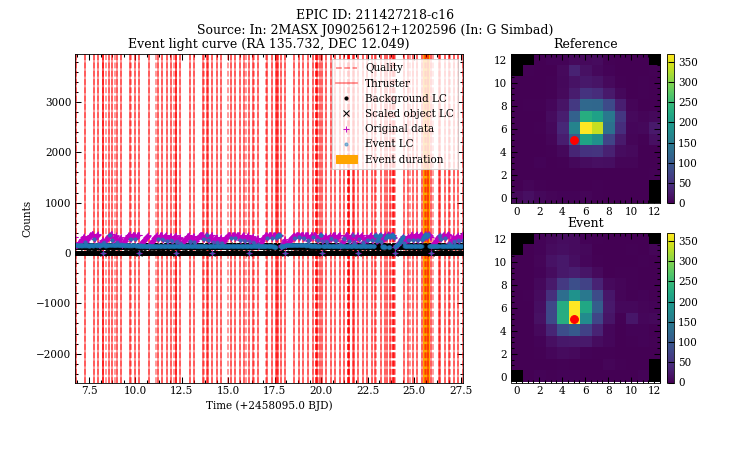

([11], [10])
x [10]
y [11]


<IPython.core.display.Javascript object>


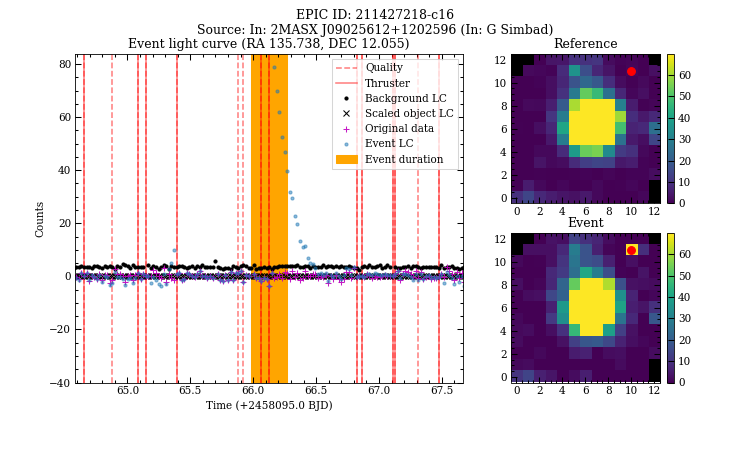

In [257]:
pixelfile = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo211545516-c16_lpd-targ.fits.gz'#ktwo203830112-c112_lpd-targ.fits.gz'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2'

try:
    hdu = fits.open(pixelfile)
    dat = hdu[1].data
    datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
    if datacube.shape[1] > 1 and datacube.shape[2] > 1:
        print('in')
        ind = np.where(np.isfinite(datacube[0]))
        for i in range(len(ind)):
            lc = datacube[:,ind[0][i],ind[1][i]]
            datacube[sigma_clip(lc,sigma=3.).mask,ind[0][i],ind[1][i]] = np.nan
        
        # section for loading in fake event
        #Start = 100
        #Position = [6,1]
        #datacube[Start:,Position[0],Position[1]] = datacube[Start:,Position[0],Position[1]] #+ K2Kilonova(-1,20,time,Start)[Start:]
        
        time = dat["TIME"] + 2454833.0
        Qual = hdu[1].data.field('QUALITY')
        thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
        thrusters = np.insert(thrusters,0,-1)
        thrusters = np.append(thrusters,len(datacube)-2)
        quality = np.where(Qual != 0)[0]
        
        xdrif = dat['pos_corr1']
        ydrif = dat['pos_corr2']
        distdrif = np.sqrt(xdrif**2 + ydrif**2)
        goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
        #calculate the reference frame
        if len(goodthrust) > 4:
            Framemin = goodthrust[3]+1
        elif len(goodthrust) > 0:
            Framemin = goodthrust[0]+1
        else:
            Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
        # Apply object mask to data
        Mask = ThrustObjectMask(datacube,goodthrust)

        #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
        Maskdata = datacube#*Mask
        allMask = np.ones((datacube.shape[1],datacube.shape[2]))
        Maskdata = Motion_correction(Maskdata,allMask,thrusters,distdrif)#*Mask

        # Make a mask for the object to use as a test to eliminate very bad pointings
        obj = np.ma.masked_invalid(Mask).mask
        objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
        objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))

        framemask = np.zeros(Maskdata.shape)

        limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
        limit[limit<22] = 22
        framemask = ((Maskdata/limit) >= 1)
        framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

        # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 

        Eventmask = np.copy(framemask)
        Eventmask[~np.where((convolve(framemask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
        Eventmask[Qual!=0,:,:] = False


        events, eventtime, eventmask = Event_ID(Eventmask,Mask,8)
        # Eliminate events that do not meet thruster firing conditions
        events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
        events, eventtime, eventmask = Match_events(events,eventtime,eventmask)
        temp = []
        for i in range(len(events)):
            if len(np.where(datacube[eventtime[i][0]:eventtime[i][-1],eventmask[i][0],eventmask[i][1]] > 100000)[0]) == 0:
                temp.append(i)
        eventtime = eventtime[temp]
        events = events[temp]
        temp2=[]
        for i in temp:
            temp2.append(eventmask[i])
        eventmask = temp2



        # Create an array that saves the total area of mask and time. 
        # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
        # Define the coordinate system 
        funny_keywords = {'1CTYP4': 'CTYPE1',
                          '2CTYP4': 'CTYPE2',
                          '1CRPX4': 'CRPIX1',
                          '2CRPX4': 'CRPIX2',
                          '1CRVL4': 'CRVAL1',
                          '2CRVL4': 'CRVAL2',
                          '1CUNI4': 'CUNIT1',
                          '2CUNI4': 'CUNIT2',
                          '1CDLT4': 'CDELT1',
                          '2CDLT4': 'CDELT2',
                          '11PC4': 'PC1_1',
                          '12PC4': 'PC1_2',
                          '21PC4': 'PC2_1',
                          '22PC4': 'PC2_2'}
        mywcs = {}
        for oldkey, newkey in funny_keywords.items():
            mywcs[newkey] = hdu[1].header[oldkey] 
        mywcs = WCS(mywcs)

        # Save thrusts and quality flags and time 
        Fieldprop = {}
        Fieldprop['File'] = pixelfile
        Fieldprop['Thruster'] = len(thrusters)
        Fieldprop['Quality'] = len(quality)-len(thrusters)
        Fieldprop['Duration'] = len(time)
        Fieldprop['Gal_lat'] = Get_gal_lat(mywcs,datacube)

        # Find all spatially seperate objects in the event mask.
        Objmasks = Identify_masks(obj)
        Objmasks = np.array(Objmasks)
        
        if len(events) > 0:
            Source, SourceType = Database_event_check(Maskdata,eventtime,eventmask,mywcs)
            ObjName, ObjType = Database_check_mask(datacube,thrusters,Objmasks,mywcs)
            Near = Near_which_mask(eventmask,Objmasks,datacube)
            In = In_which_mask(eventmask,Objmasks,datacube)
            Maskobj = np.zeros((len(events),Maskdata.shape[1],Maskdata.shape[2])) # for plotting masked object reference
            if len(np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]) > 0:
                CentralMask = np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]
            elif len(np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]) > 1:
                CentralMask = np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0][0]
            else:
                CentralMask = -1
            if CentralMask == -1:
                Maskobj[:] = Mask
            else:
                Maskobj[:] = Objmasks[CentralMask]

            for ind in np.where(Near != -1)[0]:
                Source[ind] = 'Near: ' + ObjName[Near[ind]]
                SourceType[ind] = 'Near: ' + ObjType[Near[ind]]
                Maskobj[ind] = Objmasks[Near[ind]]
            for ind in np.where(In != -1)[0]:
                Source[ind] = 'In: ' + ObjName[In[ind]]
                SourceType[ind] = 'In: ' + ObjType[In[ind]]
                Maskobj[ind] = Objmasks[In[ind]]

            SourceType = Isolation(eventtime,eventmask,Maskdata,SourceType)


            # Print figures
            K2TranPixFig(events,eventtime,eventmask,Maskdata,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin,datacube,Source,SourceType,Maskobj)
            #K2TranPixGif(events,eventtime,eventmask,Maskdata,mywcs,save,pixelfile,Source,SourceType)


except (ValueError):
    pass

In [3]:
import lightkurve as lk

In [78]:
def SixMedian(LC):
    lc6 = []
    x = []
    for i in range(int(len(LC)/12)):
        lc6.append(np.nanmedian(LC[i*12:(i*12)+12]))
        x.append(i*12+6)
    lc6 = np.array(lc6)
    x = np.array(x)
    return lc6, x

In [73]:
pixelfile = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo203830112-c112_lpd-targ.fits.gz'#ktwo203830112-c112_lpd-targ.fits.gz'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2'

hdu = fits.open(pixelfile)
dat = hdu[1].data
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
if datacube.shape[1] > 1 and datacube.shape[2] > 1:
    print('in')
    ind = np.where(np.isfinite(datacube[0]))
    for i in range(len(ind)):
        lc = datacube[:,ind[0][i],ind[1][i]]
        datacube[sigma_clip(lc,sigma=3.).mask,ind[0][i],ind[1][i]] = np.nan
    datacube[datacube == 0] = np.nan
    # section for loading in fake event
    #Start = 100
    #Position = [6,1]
    #datacube[Start:,Position[0],Position[1]] = datacube[Start:,Position[0],Position[1]] #+ K2Kilonova(-1,20,time,Start)[Start:]

    time = dat["TIME"] + 2454833.0
    Qual = hdu[1].data.field('QUALITY')
    thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
    thrusters = np.insert(thrusters,0,-1)
    thrusters = np.append(thrusters,len(datacube)-2)
    quality = np.where(Qual != 0)[0]

    xdrif = dat['pos_corr1']
    ydrif = dat['pos_corr2']
    distdrif = np.sqrt(xdrif**2 + ydrif**2)
    goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
    #calculate the reference frame
    if len(goodthrust) > 4:
        Framemin = goodthrust[3]+1
    elif len(goodthrust) > 0:
        Framemin = goodthrust[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(datacube,goodthrust)

    #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
    Maskdata = np.copy(datacube)#*Mask
    allMask = np.ones((datacube.shape[1],datacube.shape[2]))
    Maskdata = Motion_correction(Maskdata,allMask,thrusters,distdrif)#*Mask
    datacube[datacube == 0] = np.nan
    
    framemask = np.zeros(Maskdata.shape)
    
    limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
    limit[limit<22] = 22
    framemask = ((Maskdata/limit) >= 1)
    framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

    # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 

    Eventmask = np.copy(framemask)
    Eventmask[~np.where((convolve(framemask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
    Eventmask[Qual!=0,:,:] = False
    
    obj = np.ma.masked_invalid(Mask).mask
    objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
    objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))
    
    Objmasks = Identify_masks(obj)
    Objmasks = np.array(Objmasks)
    
    funny_keywords = {'1CTYP4': 'CTYPE1',
                  '2CTYP4': 'CTYPE2',
                  '1CRPX4': 'CRPIX1',
                  '2CRPX4': 'CRPIX2',
                  '1CRVL4': 'CRVAL1',
                  '2CRVL4': 'CRVAL2',
                  '1CUNI4': 'CUNIT1',
                  '2CUNI4': 'CUNIT2',
                  '1CDLT4': 'CDELT1',
                  '2CDLT4': 'CDELT2',
                  '11PC4': 'PC1_1',
                  '12PC4': 'PC1_2',
                  '21PC4': 'PC2_1',
                  '22PC4': 'PC2_2'}
    mywcs = {}
    for oldkey, newkey in funny_keywords.items():
        mywcs[newkey] = hdu[1].header[oldkey] 
    mywcs = WCS(mywcs)
    
tpf = lk.KeplerTargetPixelFile(pixelfile)

in


In [131]:
def Long_events(Data,Dist):
    '''
    Simple search for pixels that experience events longer than 2 days.
    '''
    
    sub = np.zeros(Data[0].shape)
    good_frames = np.where(Dist < 0.5)[0]

    dim1,dim2 = tpf.flux[0].shape
    for i in range(dim1):
        for j in range(dim2):
            lc = Data[good_frames,i,j]
            sub[i,j] = abs((np.nanmean(lc) - np.nanmedian(lc)))

    cut = np.nanmedian(sub) + np.nanstd(sub)

    
    long_events = Identify_masks(sub>=cut)
    
    long_mask = []
    
    for i in range(len(long_events)):
        lc = np.nansum(datacube*long_events[i],axis=(1,2))
        lc[lc <= 0] = np.nan
    
        if len(lc[lc > np.nanmean(lc)]) > 48*2:
            long_mask.append(long_events[i])
    
    return long_mask

def In_long_mask(Eventmask,Objmasks,Data):
    '''
    Finds which mask in the object mask an event is in. The value assigned to In_mask 
    is the index of Objmask that corresponds to the event. If not mask is near, value is -1.
    '''
    In_mask = np.ones(len(Eventmask),dtype=int)*-1
    for j in range(len(Eventmask)):
        mask = Eventmask[j]
        
        for i in range(len(Objmasks)):
            in_mask = (mask*Objmasks[i]).any()
            
            if in_mask:
                In_mask[j] = int(i)
    return In_mask

def Long_save_environment(maxcolor,Source,SourceType,Save):
    '''
    Makes a save pathway for the long event search. All events will be saved under a VLong directory.
    '''
    if maxcolor <= 24:
        if ':' in Source:
            Cat = Source.split(':')[0]
            directory = Save+'/Figures/VLong/Faint/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
        else:
            directory = Save+'/Figures/VLong/Faint/' + SourceType + '/'

    else:
        if ':' in Source:
            Cat = Source.split(':')[0]
            directory = Save+'/Figures/VLong/Bright/' + Cat + '/' + SourceType.split(Cat + ': ')[-1] + '/'
        else:
            directory = Save+'/Figures/VLong/Bright/' + SourceType + '/'

    Save_space(directory)
    return directory

def Long_figure(Long,Data,WCS,Time,Save,File,Source,SourceType,ObjMask,Frames):
    for i in range(len(Long)):
        mask = Long[i]
        
        #Find Coords of transient
        position = np.where(mask)
        if len(position[0]) == 0:
            print(Broken)
        Mid = ([position[0][0]],[position[1][0]])
        maxcolor = -1000 # Set a bad value for error identification
        for j in range(len(position[0])):
            temp = sorted(Data[:,position[0][j],position[1][j]].flatten())
            temp = np.array(temp)
            temp = temp[np.isfinite(temp)]
            temp  = temp[-3] # get 3rd brightest point
            if temp > maxcolor:
                maxcolor = temp
                Mid = ([position[0][j]],[position[1][j]])
        
        if len(Mid[0]) == 1:
            Coord = pix2coord(Mid[1],Mid[0],WCS)
        elif len(Mid[0]) > 1:
            Coord = pix2coord(Mid[1][0],Mid[0][0],WCS)
        
        test = np.ma.masked_invalid(Data).mask*1
        wide = convolve(test,np.ones((1,3,3))) > 0
        bgmask = -(wide*1.0+mask*1.0) + 1.0
        bgmask[bgmask==0] = np.nan
        background = Data*bgmask
        level = np.nanmedian(background,axis=(1,2))
        BG = Data*~Frames
        BG[BG <= 0] = np.nan
        BGLC = level
        # Generate a light curve from the transient masks
        LC = np.nansum(Data*mask, axis = (1,2))# - level
        Six_LC, ind = SixMedian(LC)

        Obj = ObjMask[i]
        ObjLC = np.nansum(Data*Obj,axis = (1,2))
        ObjLC = ObjLC/np.nanmedian(ObjLC)*np.nanmedian(LC)

        OrigLC = np.nansum(Data*mask, axis = (1,2))
        
        
        # Generate a light curve from the transient masks
        temp = sorted(LC.flatten())
        temp = np.array(temp)
        temp = temp[np.isfinite(temp)]
        temp = temp[-5] # get 5th brightest point
        
        max_frame = np.where(LC == temp)[0][0]
        
        mead = np.nanmedian(LC[np.isfinite(LC)])
        mead_frame = np.where(np.nanmin(abs(LC-mead)) == abs(LC-mead))[0][0]
        
        fig = plt.figure(figsize=(10,6))
        # set up subplot grid
        gridspec.GridSpec(2,3)
        plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source[i] + ' (' + SourceType[i] + ')')
        # large subplot
        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
        plt.title('Event light curve ('+str(round(Coord[0],3))+', '+str(round(Coord[1],3))+')')
        plt.xlabel('Time (+'+str(int(np.floor(Time[0])))+' BJD)')
        plt.ylabel('Counts')
        
        plt.plot(Time - np.floor(Time[0]), BGLC,'k.', label = 'Background LC')
        plt.plot(Time - np.floor(Time[0]), ObjLC,'kx', label = 'Scaled object LC')
        plt.plot(Time - np.floor(Time[0]), LC,'.', label = 'Event LC',alpha=0.5)
        plt.plot(Time[ind] - np.floor(Time[0]), Six_LC,'.', label = '6hr average',alpha=1)
        
        ymin = np.nanmin(Six_LC) - 0.1*np.nanmin(Six_LC)
        ymax = np.nanmax(Six_LC) + 0.1*np.nanmax(Six_LC)
        
        plt.ylim(ymin,ymax)
        plt.legend(loc = 1)
        plt.minorticks_on()
        
        # Set the axes limits for the imshows
        ylims, xlims = Fig_cut(Data,Mid)
        
        # small subplot 1 Reference image plot
        ax = plt.subplot2grid((2,3), (0,2))
        plt.title('Reference')
        plt.imshow(Data[mead_frame,:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.plot(position[1],position[0],'r.',ms = 12)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # small subplot 2 Image of event
        ax = plt.subplot2grid((2,3), (1,2))
        plt.title('Event')
        plt.imshow(Data[max_frame,:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.plot(position[1],position[0],'r.',ms = 12)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Save directory
        directory = Long_save_environment(maxcolor,Source[i],SourceType[i],Save)
            
        plt.savefig(directory + 'Long-' + File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')


In [59]:
long_mask = Long_events(datacube,distdrif)
Long_Source, Long_Type = Database_check_mask(datacube,thrusters,long_mask,mywcs)

if len(long_mask) > 0:
    ObjName, ObjType = Database_check_mask(datacube,thrusters,Objmasks,mywcs)
    In = In_long_mask(long_mask,Objmasks,datacube)
    Long_Maskobj = np.zeros((len(long_mask),Maskdata.shape[1],Maskdata.shape[2])) # for plotting masked object reference
    
    if len(np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]) > 0:
        CentralMask = np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]
    elif len(np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0]) > 1:
        CentralMask = np.where(Objmasks[:,int(Maskdata.shape[1]/2),int(Maskdata.shape[2]/2)] == 1)[0][0]
    else:
        CentralMask = -1
    if CentralMask == -1:
        Maskobj[:] = Mask
    else:
        Maskobj[:] = Objmasks[CentralMask]

    for ind in np.where(In != -1)[0]:
        Long_Source[ind] = 'In: ' + ObjName[In[ind]]
        Long_Type[ind] = 'In: ' + ObjType[In[ind]]
        Long_Maskobj[ind] = Objmasks[In[ind]]

In [60]:
Long_Source

['In: 2MASS J16534904-2446232', 'Unknown']

<IPython.core.display.Javascript object>


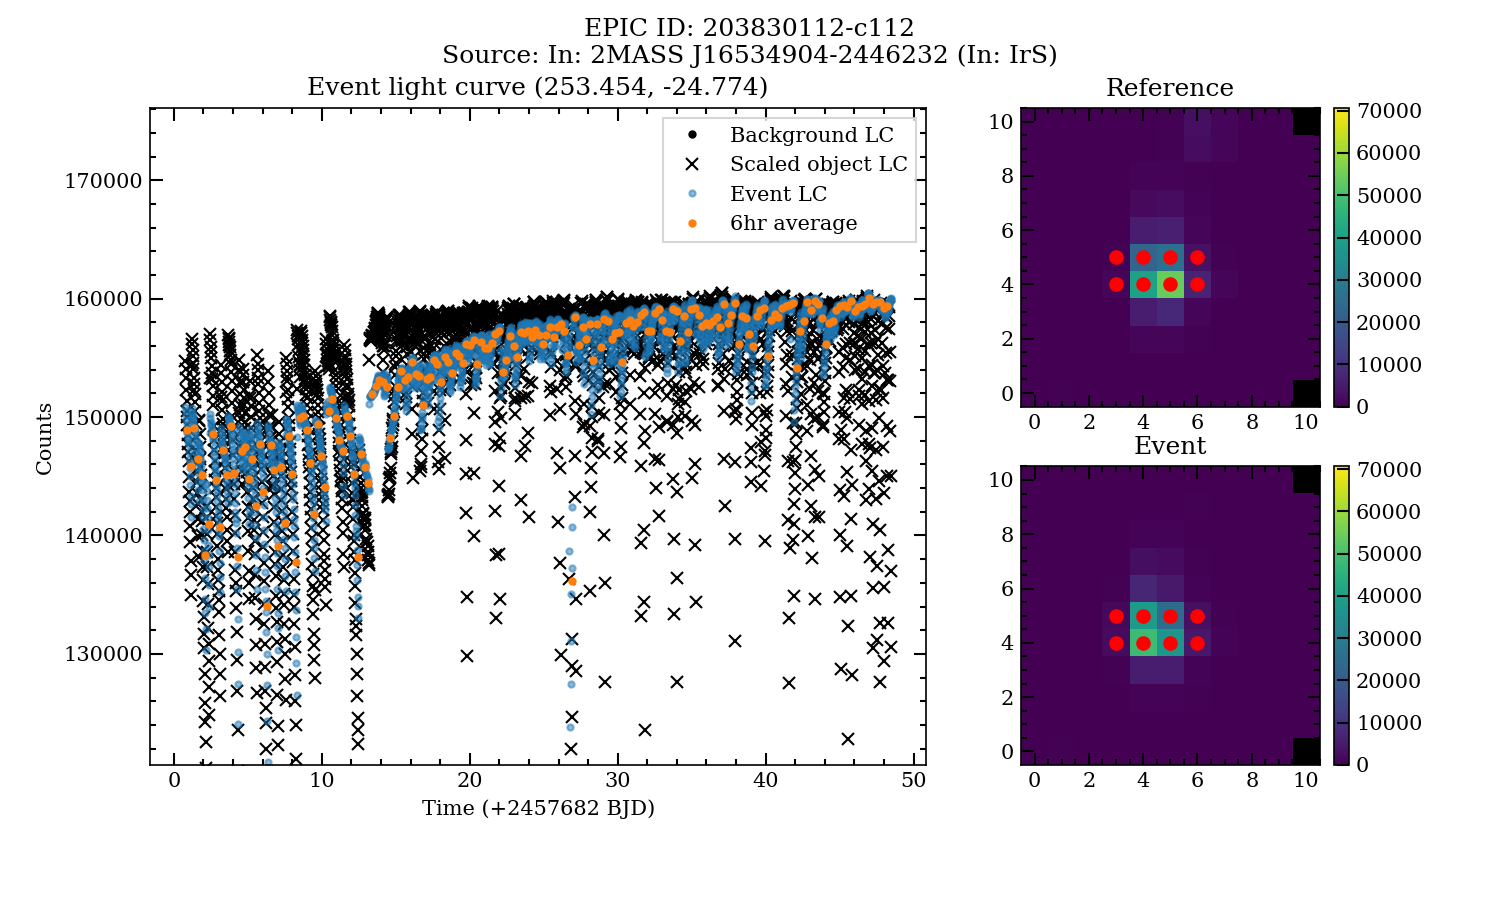

70640.086


<IPython.core.display.Javascript object>


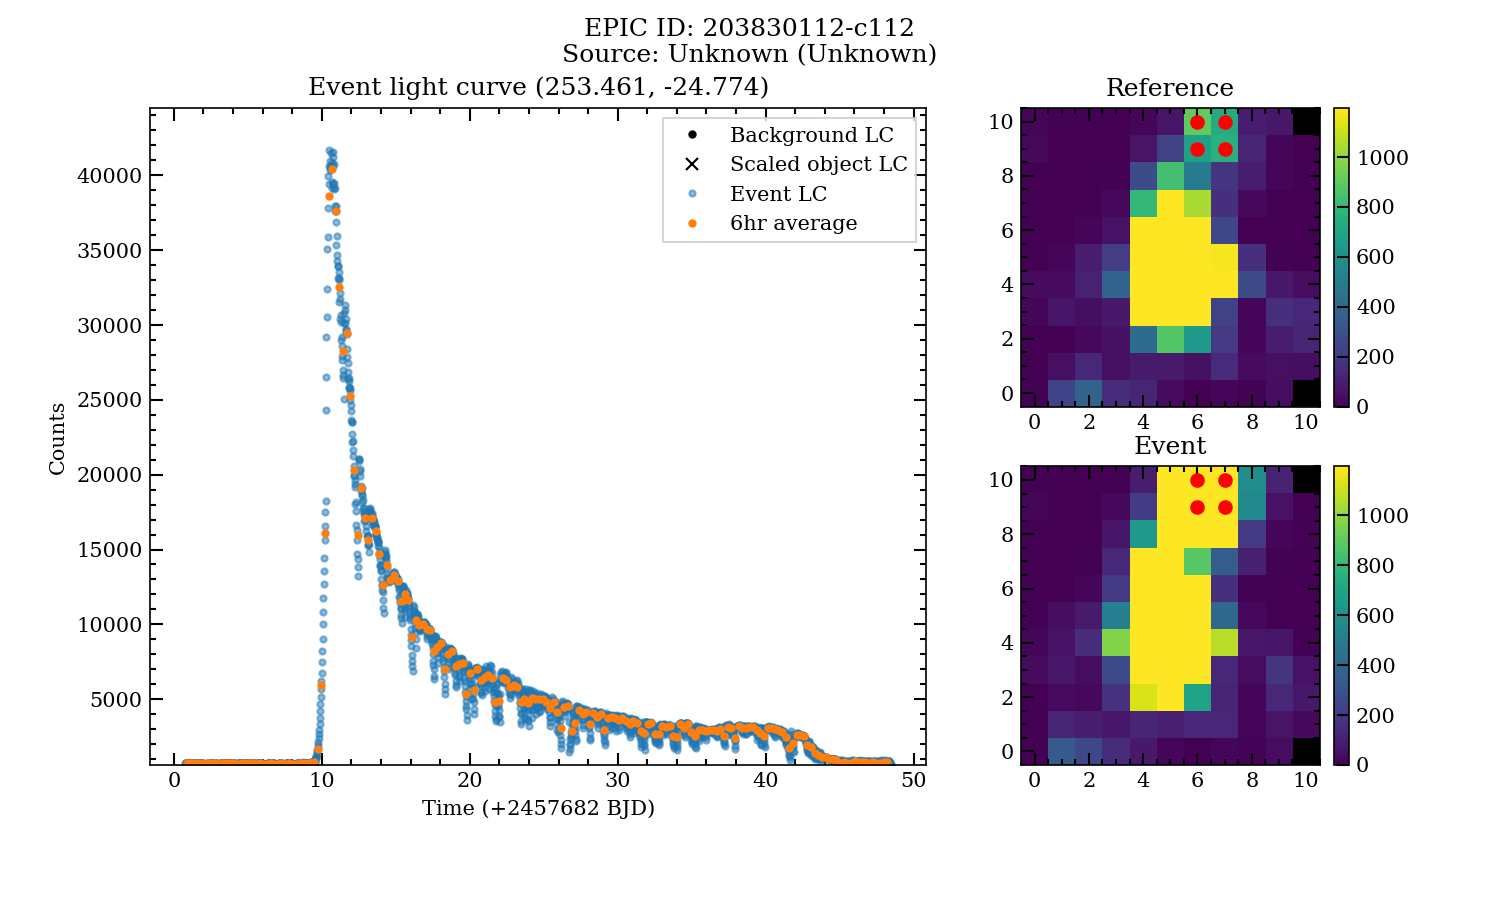

1196.6975


In [130]:
Long_figure(long_mask,datacube,mywcs,time,save,pixelfile,Long_Source,Long_Type,Long_Maskobj,Eventmask)

In [122]:
def Long_figure(Long,Data,WCS,Time,Save,File,Source,SourceType,ObjMask,Frames):
    for i in range(len(Long)):
        mask = Long[i]
        
        #Find Coords of transient
        position = np.where(mask)
        if len(position[0]) == 0:
            print(Broken)
        Mid = ([position[0][0]],[position[1][0]])
        maxcolor = -1000 # Set a bad value for error identification
        for j in range(len(position[0])):
            temp = sorted(Data[:,position[0][j],position[1][j]].flatten())
            temp = np.array(temp)
            temp = temp[np.isfinite(temp)]
            temp  = temp[-3] # get 3rd brightest point
            if temp > maxcolor:
                maxcolor = temp
                Mid = ([position[0][j]],[position[1][j]])
        
        if len(Mid[0]) == 1:
            Coord = pix2coord(Mid[1],Mid[0],WCS)
        elif len(Mid[0]) > 1:
            Coord = pix2coord(Mid[1][0],Mid[0][0],WCS)
        
        test = np.ma.masked_invalid(Data).mask*1
        wide = convolve(test,np.ones((1,3,3))) > 0
        bgmask = -(wide*1.0+mask*1.0) + 1.0
        bgmask[bgmask==0] = np.nan
        background = Data*bgmask
        level = np.nanmedian(background,axis=(1,2))
        BG = Data*~Frames
        BG[BG <= 0] = np.nan
        BGLC = level
        # Generate a light curve from the transient masks
        LC = np.nansum(Data*mask, axis = (1,2))# - level
        Six_LC, ind = SixMedian(LC)

        Obj = ObjMask[i]
        ObjLC = np.nansum(Data*Obj,axis = (1,2))
        ObjLC = ObjLC/np.nanmedian(ObjLC)*np.nanmedian(LC)

        OrigLC = np.nansum(Data*mask, axis = (1,2))
        
        
        # Generate a light curve from the transient masks
        temp = sorted(LC.flatten())
        temp = np.array(temp)
        temp = temp[np.isfinite(temp)]
        temp = temp[-5] # get 5th brightest point
        
        max_frame = np.where(LC == temp)[0][0]
        
        mead = np.nanmedian(LC[np.isfinite(LC)])
        print(mead)
        print(np.nanmin(abs(LC-mead)))
        mead_frame = np.where(np.nanmin(abs(LC-mead)) == abs(LC-mead))[0][0]
        
        fig = plt.figure(figsize=(10,6))
        # set up subplot grid
        gridspec.GridSpec(2,3)
        plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source[i] + ' (' + SourceType[i] + ')')
        # large subplot
        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
        plt.title('Event light curve ('+str(round(Coord[0],3))+', '+str(round(Coord[1],3))+')')
        plt.xlabel('Time (+'+str(int(np.floor(Time[0])))+' BJD)')
        plt.ylabel('Counts')
        
        plt.plot(Time - np.floor(Time[0]), BGLC,'k.', label = 'Background LC')
        plt.plot(Time - np.floor(Time[0]), ObjLC,'kx', label = 'Scaled object LC')
        plt.plot(Time - np.floor(Time[0]), LC,'.', label = 'Event LC',alpha=0.5)
        plt.plot(Time[ind] - np.floor(Time[0]), Six_LC,'.', label = '6hr average',alpha=1)
        
        ymin = np.nanmin(Six_LC) - 0.1*np.nanmin(Six_LC)
        ymax = np.nanmax(Six_LC) + 0.1*np.nanmax(Six_LC)
        
        plt.ylim(ymin,ymax)
        plt.legend(loc = 1)
        plt.minorticks_on()
        
        # Set the axes limits for the imshows
        ylims, xlims = Fig_cut(Data,Mid)
        
        # small subplot 1 Reference image plot
        ax = plt.subplot2grid((2,3), (0,2))
        plt.title('Reference')
        plt.imshow(Data[mead_frame,:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.plot(position[1],position[0],'r.',ms = 12)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # small subplot 2 Image of event
        ax = plt.subplot2grid((2,3), (1,2))
        plt.title('Event')
        plt.imshow(Data[max_frame,:,:], origin='lower',vmin=0,vmax = maxcolor)
        plt.xlim(xlims[0],xlims[1])
        plt.ylim(ylims[0],ylims[1])
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.plot(position[1],position[0],'r.',ms = 12)
        plt.minorticks_on()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Save directory
        directory = Long_save_environment(maxcolor,Source[i],SourceType[i],Save)
            
        plt.savefig(directory + 'Long-' + File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')

<IPython.core.display.Javascript object>


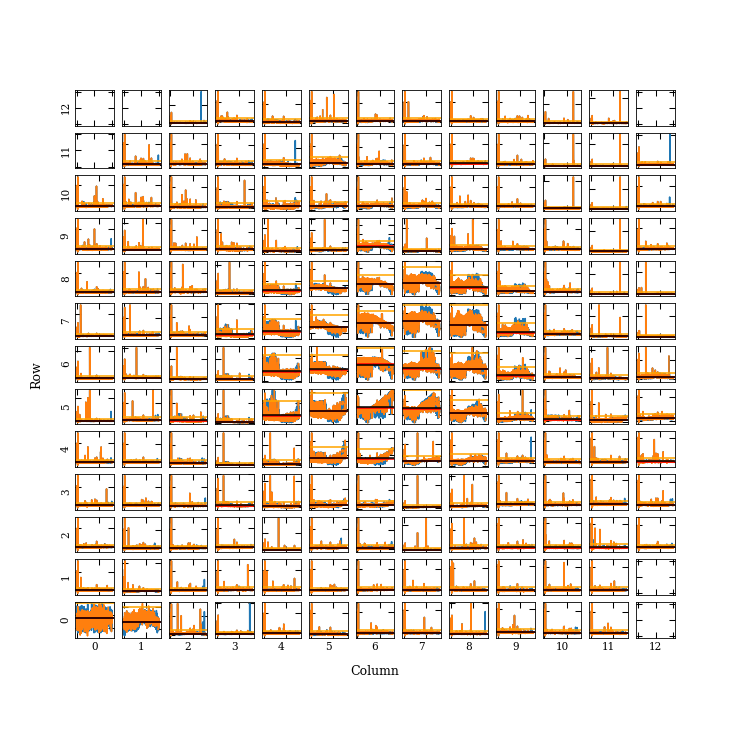

Text(0.04,0.5,'Row')

In [259]:
mean = []
median = []

dim1,dim2 = tpf.flux[0].shape
fig = plt.figure(figsize=(10,10))
k = 0
for i in range(dim1):
    for j in range(dim2):
        lc = datacube[:,dim1-1-i,j]
        lc2 = Maskdata[:,dim1-1-i,j]
#        lc = medfilt(lc)
        
        plt.subplot(dim1,dim2,k+1)
        plt.plot(time - time[0],lc,'-')
        plt.plot(time - time[0],lc2,'-')
        plt.axhline(np.nanmedian(lc) + 3*np.nanstd(lc),color='orange')
        plt.axhline(np.nanmedian(lc),color='red')
        plt.axhline(np.nanmean(lc),color='black')
        mean.append(np.nanmean(lc))
        median.append(np.nanmedian(lc))
        #plt.xlim(30,40)
        plt.tick_params(axis='x',which='both', labelbottom=False)    
        plt.tick_params(axis='y',which='both', labelleft=False)    
        if j == 0:
            plt.ylabel(str(dim1-1-i))
        if i == dim1-1:
            plt.xlabel(str(j))
        k += 1
fig.text(0.5, 0.1, 'Column', ha='center',size = 'large')
fig.text(0.04, 0.5, 'Row', va='center', rotation='vertical',size = 'large')

In [260]:
mean = np.array(mean)
median = np.array(median)

<IPython.core.display.Javascript object>


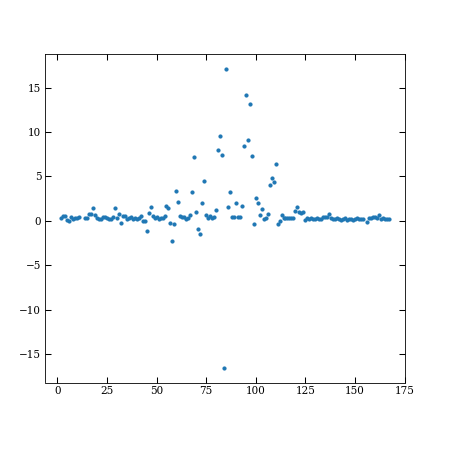

In [261]:
plt.figure()
plt.plot(mean-median,'.')

In [65]:
np.nanmedian(abs(mean-median))

0.3830910183691225

In [142]:
np.nanstd((mean-median)/median)

0.7238381139436625

In [125]:
np.where(abs(mean-median) >= 5)

(array([  5,   6,   7,   8,  14,  16,  17,  18,  19,  20,  25,  26,  27,
         28,  29,  30,  31,  36,  37,  38,  39,  40,  41,  42,  43,  47,
         48,  49,  50,  51,  52,  57,  58,  59,  60,  61,  62,  63,  68,
         69,  70,  71,  72,  73,  74,  76,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  89,  91,  92,  93,  94,  95,  96,  97,  99, 100,
        104, 106, 107, 111, 113, 115]),)

In [160]:
np.where(distdrif < 0.3)

(array([  21,   22,   23, ..., 2327, 2328, 2329]),)

In [212]:
sub

array([[-2.11094899e-03, -6.30182997e-03,  9.52488398e-03,
         5.31032134e-01,  1.24179744e+00, -9.85595956e-02,
        -1.97119059e-01,  6.67031296e-02],
       [-8.78689752e+00,  2.00478994e-02, -4.03375594e-02,
         3.27487546e-03,  2.07493786e-01,  5.49143333e-02,
         6.88594129e-01,  3.88578747e-01],
       [-1.72652651e-01, -1.36216389e-01, -1.73156086e-01,
        -1.85521731e-01,  6.78968548e-02,  1.05723492e-01,
         3.16488759e-02, -8.22409897e-02],
       [ 1.92033981e-01,  1.22891956e-01, -2.95311707e-01,
        -2.93307791e-01,  2.56926870e-01,  1.25275895e-01,
         2.12272764e-02, -2.26145907e-01],
       [-2.23664910e-01, -3.00569000e-01, -1.55476048e-01,
        -1.83903246e-01, -6.58608809e-01,  1.43898241e-02,
        -9.78615089e-02, -5.22241412e-02],
       [ 3.81148658e-01, -6.63529777e-01, -5.30178447e-01,
         7.68405956e-02,  9.22779199e-02,  6.67835308e-02,
         4.12085819e-01,  5.38921374e-03],
       [ 4.51543220e-02, -1.762544

<IPython.core.display.Javascript object>


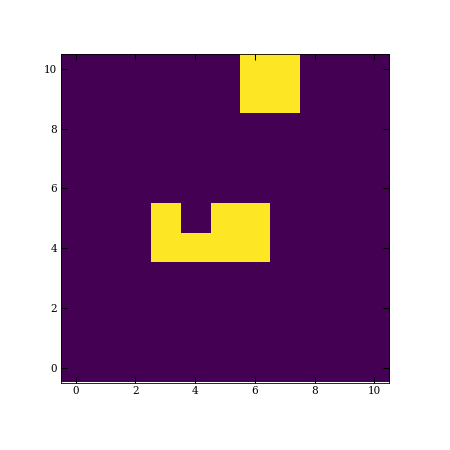

In [240]:
plt.figure()
plt.imshow(sub>=cut,origin='lower')
#plt.colorbar()

In [241]:
test = Identify_masks(sub>=cut)

In [242]:
test[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>


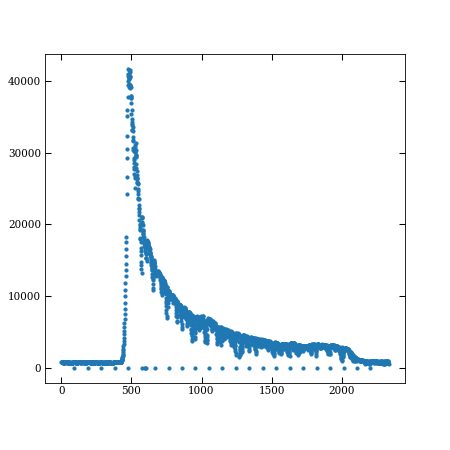

In [244]:
plt.figure()
plt.plot(np.nansum(datacube*test[1],axis=(1,2)),'.')

<IPython.core.display.Javascript object>


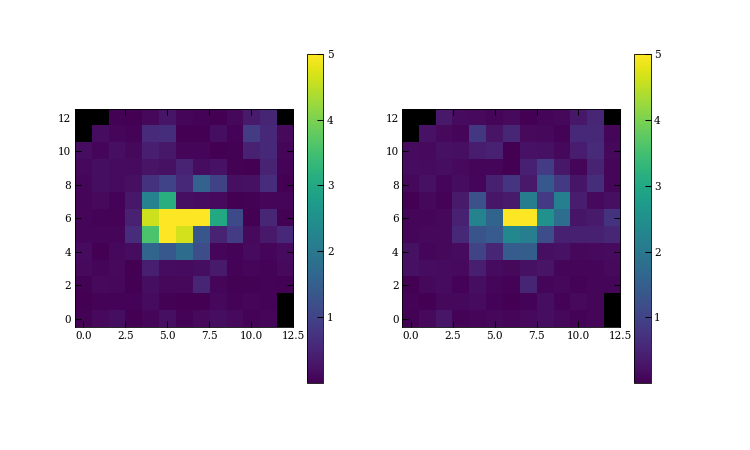

In [272]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(sub,origin='lower',vmax=5)
plt.colorbar()

plt.subplot(122)
plt.imshow(sub2,origin='lower',vmax=5)
plt.colorbar()

In [112]:
pixelfile

'/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo211545516-c16_lpd-targ.fits.gz'

5.373771340593906


<IPython.core.display.Javascript object>


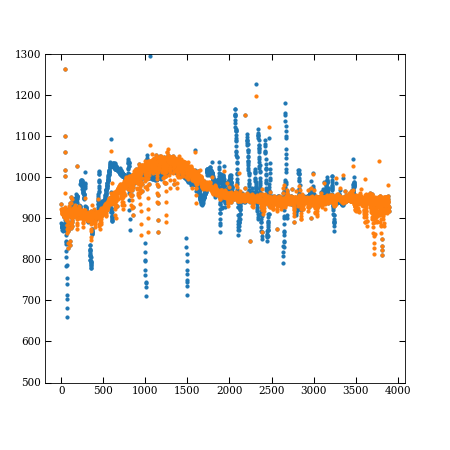

(500, 1300)

In [114]:
cut = np.nanmedian(sub) + np.nanstd(sub)
cut2 = np.nanmedian(sub2) + np.nanstd(sub2)
if cut < 5:
    cut = 5
print(cut)

lc = np.nansum(datacube*(sub >= cut),axis=(1,2))
lc2 = np.nansum(Maskdata*(sub >= cut),axis=(1,2))

plt.figure()
plt.plot(lc2,'.')
plt.plot(lc,'.')
plt.ylim(500,1300)

<IPython.core.display.Javascript object>


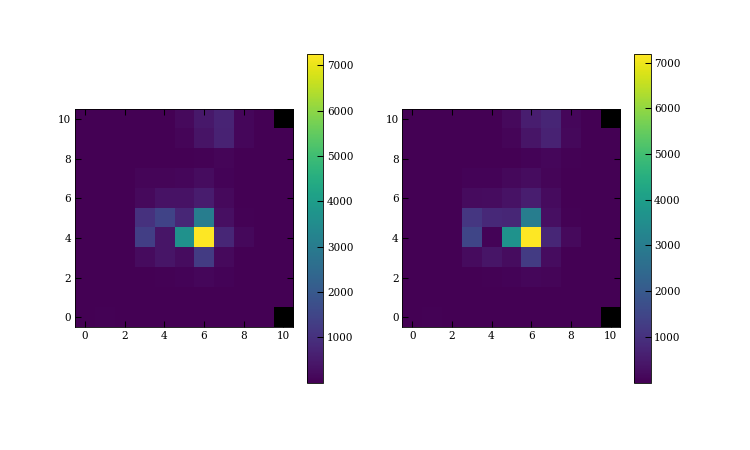

In [137]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(sub2,origin='lower')
plt.colorbar()

plt.subplot(122)
plt.imshow(sub,origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


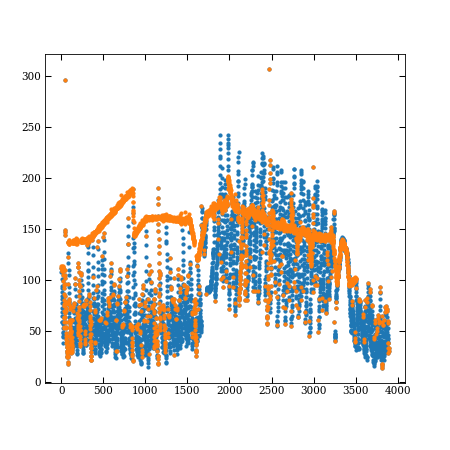

<IPython.core.display.Javascript object>


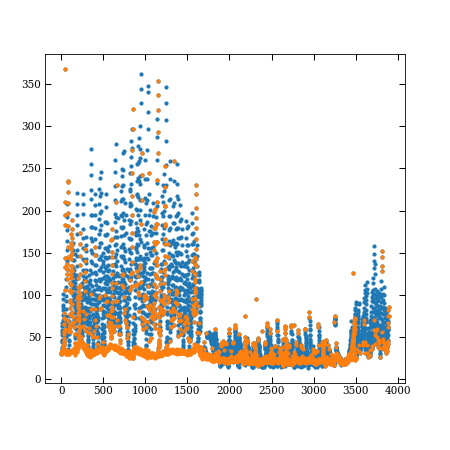

<IPython.core.display.Javascript object>


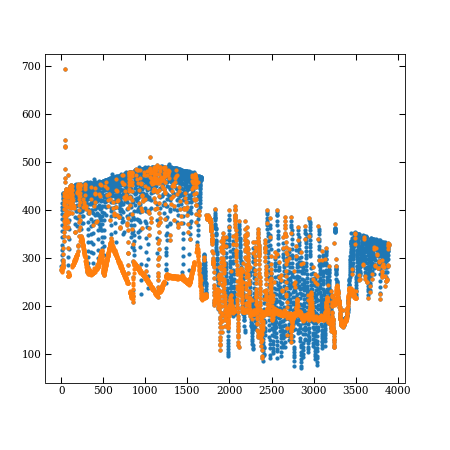

<IPython.core.display.Javascript object>


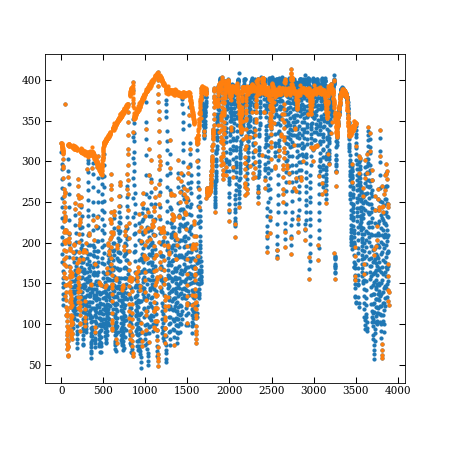

<IPython.core.display.Javascript object>


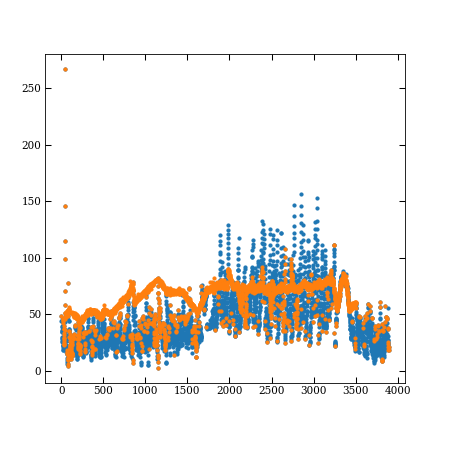

<IPython.core.display.Javascript object>


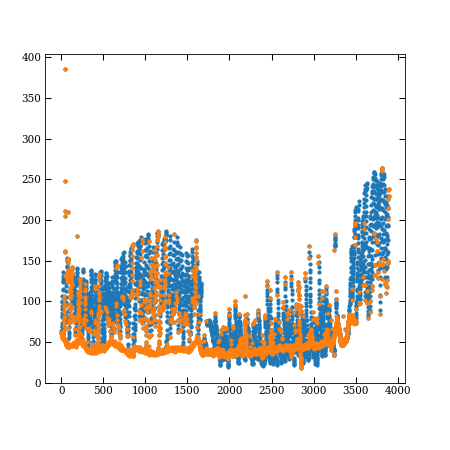

<IPython.core.display.Javascript object>


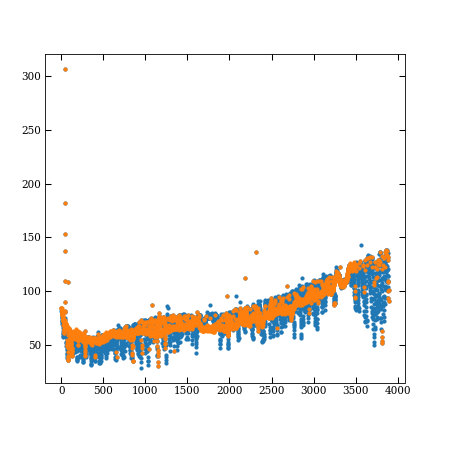

In [111]:
x, y = np.where(sub >= cut)

for i in range(len(x)):
    plt.figure()
    plt.plot(datacube[:,x[i],y[i]],'.')
    plt.plot(Maskdata[:,x[i],y[i]],'.')


## Real position

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [ ]:
cord = pix2coord(1,3,mywcs)

In [ ]:
Coord = SkyCoord(cord[0],cord[1],unit=(u.deg))

In [ ]:
position = np.where(eventmask[0])
maxcolor = np.nanmax(Maskdata[eventtime[0][0]:eventtime[0][-1]]*(eventmask[0]==1))
Mid = np.where(Maskdata[eventtime[0][0]:eventtime[0][-1]]*(eventmask[0]==1) == maxcolor)

In [ ]:
eventtime[-3]

## Light curve of pixels around the brightest pixels

In [ ]:
newmask = np.zeros((Maskdata.shape[1],Maskdata.shape[2]))
newmask[Mid[1],Mid[2]] = 1
surround = convolve(newmask, np.ones((3,3)), mode='constant', cval=0.0) - newmask
pixpos = np.where(surround == 1)
plt.figure()
plt.plot(np.nansum(newmask*Maskdata,axis=(1,2)),'.',label='Central '+ str(Mid[1][0])+','+str(Mid[2][0]))
for i in range(int(np.nansum(surround))):
    plt.plot(Maskdata[:,pixpos[0][i],pixpos[1][i]], '.',label=str(pixpos[0][i])+','+str(pixpos[1][i]))
plt.xlim(360, 370)
plt.legend()
    

## Derivative of the pixels

In [ ]:
newmask = np.zeros((Maskdata.shape[1],Maskdata.shape[2]))
newmask[Mid[1],Mid[2]] = 1
surround = convolve(newmask, np.ones((3,3)), mode='constant', cval=0.0) - newmask
pixpos = np.where(surround == 1)
plt.figure()
plt.plot(np.diff(np.nansum(newmask*Maskdata,axis=(1,2))),'-',label='Central '+ str(Mid[1][0])+','+str(Mid[2][0]))
for i in range(int(np.nansum(surround))):
    plt.plot(np.diff(Maskdata[:,pixpos[0][i],pixpos[1][i]]), '-',label=str(pixpos[0][i])+','+str(pixpos[1][i]))
plt.xlim(360, 370)
#plt.legend(loc='left')
    

In [ ]:
np.diff(np.nansum(newmask*Maskdata,axis=(1,2))) - np.roll(np.diff(Maskdata[:,3,15]),1)

In [ ]:
plt.figure()
plt.plot(np.diff(np.nansum(newmask*Maskdata,axis=(1,2))),'--',alpha = 0.5)
plt.plot(np.roll(np.diff(Maskdata[:,3,15]),1),'--',alpha = 0.5)
plt.plot(np.diff(np.nansum(newmask*Maskdata,axis=(1,2))) - np.roll(np.diff(Maskdata[:,3,15]),1))

plt.xlim(360, 370)

## Residuals 

In [ ]:
plt.figure()
plt.plot((np.diff(np.nansum(newmask*Maskdata,axis=(1,2))) - np.roll(np.diff(Maskdata[:,3,15]),1))/np.diff(np.nansum(newmask*Maskdata,axis=(1,2))))
plt.ylim(-1,1)
plt.xlim(360, 370)

## Looking at 201736342-c01

In [ ]:
from ipywidgets import interact
from ipywidgets import interact, interactive, fixed, interact_manual

In [ ]:
def plttpf(f):
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    ax1.plot(time-time[0], np.nansum(datacube*eventmask[-3],axis=(1,2)), 'r.', alpha=0.7,label='First detection')
    ax1.plot(time-time[0], np.nansum(datacube*eventmask[-2],axis=(1,2)), '.',color='orange', alpha=0.7,label='Second detection')

    ax1.set_ylim(0, 150)
    ax1.set_xlim(7, 14)
    ax1.axvline(time[f]-time[0],color='black')
    ax1.legend()
    ax1.set_ylabel('Counts')
    ax1.set_xlabel('Time (days)')
    
    im = ax2.imshow(datacube[f, :,:],vmin = 0,vmax = 60,origin='lower')
    ax2.plot(np.where(eventmask[-3]==1)[1],np.where(eventmask[-3]==1)[0],'r.')
    ax2.plot(np.where(eventmask[-2]==1)[1],np.where(eventmask[-2]==1)[0],'.',color='orange')
    c = plt.colorbar(im)
    c.set_label('Counts')
    fig.set_size_inches((10,4))
    plt.savefig(save+'/wanderer/'+'Frame_' + str(int(f-360)).zfill(4)+'.png')
    plt.close();

In [ ]:
interact(plttpf, f=(200,800,1));

## Cataclysmic variable

In [ ]:
def K2TranPixCompFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube,Source,SourceType):
    position = np.where(Eventmask)
    maxcolor = np.nanmax(Datacube[Eventtime[0]:Eventtime[-1]]*(Eventmask==1))
    Mid = np.where(Datacube[Eventtime[0]:Eventtime[-1]]*(Eventmask==1) == maxcolor)
    Coord = pix2coord(Mid[2],Mid[1],wcs)
    # Generate a light curve from the transient masks
    LC = np.nansum(Data*Eventmask, axis = (1,2))
    BG = Datacube*~Frames[Events]
    BG[BG <= 0] =np.nan
    BGLC = np.nanmedian(BG, axis = (1,2))


    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gridspec.GridSpec(2,3)
    plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source + ' (' + SourceType + ')')
    # large subplot
    plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
    plt.title('Event light curve (BJD '+str(round(Time[Eventtime[0]]-np.floor(Time[0]),2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
    plt.xlabel('Time (+'+str(np.floor(Time[0]))+' BJD)')
    plt.ylabel('Counts')
    plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
    plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
    plt.minorticks_on()

    if Eventtime[-1] < len(Time):
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[Eventtime[-1]]-np.floor(Time[0]), color = 'orange', label = 'Event duration')
    else:
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[-1]-np.floor(Time[0]), color = 'orange', label = 'Event duration')
    '''
    plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
    for j in range(Quality.shape[0]-1):
        j = j+1 
        plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
    # plot Thurster firings 

    plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
    for j in range(Thrusters.shape[0]-1):
        j = j+1 
        plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
    '''
    xmin = Time[Eventtime[0]]-Time[0]-(Eventtime[-1]-Eventtime[0])/10
    xmax = Time[Eventtime[-1]]-Time[0]+(Eventtime[-1]-Eventtime[0])/10
    if xmin < 0:
        xmin = 0
    if xmax > Time[-1] - np.floor(Time[0]):
        xmax = Time[-1] - np.floor(Time[0])
    plt.xlim(xmin,xmax) # originally 48 for some reason
    plt.ylim(np.nanmedian(LC)-np.nanstd(LC),np.nanmax(LC[Eventtime[0]:Eventtime[-1]])+0.1*np.nanmax(LC[Eventtime[0]:Eventtime[-1]]))
    plt.legend(loc = 1)
    # small subplot 1 Reference image plot
    plt.subplot2grid((2,3), (0,2))
    plt.title('Reference')
    plt.imshow(Datacube[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='black')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.plot(position[1],position[0],'r.',ms = 15)
    # small subplot 2 Image of event
    plt.subplot2grid((2,3), (1,2))
    plt.title('Event')
    plt.imshow(Datacube[np.where(Datacube*Eventmask==np.nanmax(Datacube[Eventtime[0]:Eventtime[-1]]*Eventmask))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='black')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.plot(position[1],position[0],'r.',ms = 15),plt.savefig(Save+'-4day.pdf')
    plt.savefig('230533709CustomMask.pdf')

In [ ]:
Compmask = np.zeros((datacube.shape[1],datacube.shape[2]))
Compmask[[228,229],[6,7]] = 1
np.where(Compmask)

In [ ]:
K2TranPixCompFig(events[1],eventtime[1],Compmask,datacube,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin,datacube,Source[1],SourceType[1])       

In [ ]:
plt.figure()
plt.plot(time-time[0],xdrif,'.', label = '$x$ displacement')
plt.plot(time-time[0],ydrif,'.', label = '$y$ displacement')
plt.xlim(15,23.5)
plt.title('Motion for 230533709')
plt.ylabel('Displacement (pixels)')
plt.xlabel('Time days (+'+str(np.floor(time[0]))+')')
plt.legend(loc='best')
plt.savefig('Motion230533709.pdf')

In [ ]:
plt.figure()
plt.plot(time-np.floor(time[0]),np.nansum(datacube*Compmask,axis=(1,2)),'.')
plt.xlabel('Time days (+'+str(np.floor(time[0]))+')')
plt.ylabel('Counts')
plt.minorticks_on()
plt.tight_layout()
plt.xlim(9.6,12)
plt.savefig('203830112peak.pdf')

In [ ]:
np.nanmax(np.nansum(datacube*Compmask,axis=(1,2)))

## Test code for motion correction

In [ ]:
X = [10]#np.where(Mask == 1)[0]
Y = [7]#np.where(Mask == 1)[1]
test2 = []
test2 = np.copy(datacube[:,X,Y])
Data = datacube
Thrusters = thrusters
Dist = distdrif


fit = np.zeros(len(Data))
for j in range(len(X)):
    temp = np.copy(Data[:,X[j],Y[j]])
    zz = np.arange(0,len(Data))
    AvSplineind = []
    for i in range(len(Thrusters)-1):
        beep = []
        beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
        if (beep < 0.3).any():
            datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
            val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
            if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
                AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
    AvSplineind = np.array(AvSplineind)


    if len(AvSplineind) > 1:
        AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
        Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=np.nan, bounds_error = False)
        Spline = Splinef(zz)

        for i in range(len(Thrusters)-1):

            if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                try:
                    Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                    temp2 = np.copy(Section)
                    x = np.arange(0,len(Section))
                    #limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                    #yo = np.where(np.diff(np.diff(Section))>limit)[0]
                    '''
                    if len(yo)/2 == int(len(yo)/2):
                        z = 0
                        while z + 1 < len(yo):
                            yoarr = np.arange(yo[z],yo[z+1])
                            temp2[yoarr] = np.nan
                            yo = np.delete(yo,[0,1])
                    else:
                        z = 0
                        while z + 2 < len(yo):
                            yoarr = np.arange(yo[z],yo[z+1])
                            temp2[yoarr] = np.nan
                            yo = np.delete(yo,[0,1])
                    if len(yo) == 1:
                        temp2[yo] = np.nan
                    '''
                    ind = np.where(~np.isnan(temp2))[0]
                    
                    if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                        polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                        p3 = np.poly1d(polyfit)
                        #print(resid/len(x[ind])/np.nanmean(Section[ind]))
                        if (resid/np.nanmean(Section[ind])) < 10:
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                        #if Thrusters[i] > 500:
                           # plt.figure()
                           # plt.plot(x+Thrusters[i]+2, np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]))
                           # plt.plot(x+Thrusters[i]+2, np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) )
                            fit[x+Thrusters[i]+2] = p3(x)
                    else:
                        print('copy')
                        temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]])
                except RuntimeError:
                    pass
    plt.figure()
    plt.plot(Data[:,10,7])
    plt.plot(temp-fit)

In [ ]:
plt.figure()
plt.plot(fit)

In [ ]:

plt.figure()
for i in thrusters:
    plt.axvline(i,color='red',alpha=0.7)
    if i == 0:
        plt.axvline(i,color='red',alpha=0.7,label = 'Thruster')
plt.plot(datacube[:,X,Y],'o',label='Data')
plt.plot(fit+Spline,'-',label='Cubic fit')
plt.plot(temp,'mx',label='Corrected data')

plt.plot(Spline,'k--',label='Spline')
#plt.plot(test[:,X,Y],'.-',label='MCF data')
#plt.plot(testspline[],'-',label='test Spline')


plt.ylabel('Counts')
plt.xlabel('Cadences')
#plt.xlim(2300,2500)
#plt.ylim(50,200)
plt.legend()
plt.title('EPIC ID: 246667478-c13 \n Pixel: (5,8)')
plt.tight_layout()
plt.minorticks_on()
#plt.savefig(save+'MC_example_talk.pdf')

In [ ]:
def K2TranPixGif(Events,Eventtime,Data,Save,File,Source,SourceType):
    # Save the frames to be combined into a gif with ffmpeg with another set of code.
    for i in range(len(Events)):
        xmin = Eventtime[i][0] - 2*(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1] + 2*(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]

        FrameSave = Save + '/Figures/Frames/' + File.split('/')[-1].split('-')[0] + '/Event_' + str(int(i)) + '/'

        Save_space(FrameSave)
        
        for j in range(Section.shape[0]):
            filename = FrameSave + 'Frame_' + str(int(j)).zfill(4)+".png"
            fig = plt.figure()
            fig.set_size_inches(6,6)
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = 20, animated=True)
            plt.title(File.split('/')[-1].split('-')[0])
            c = plt.colorbar(fraction=0.046, pad=0.04)
            c.set_label('Counts')


            plt.savefig(filename)
            plt.close();

        directory = Save_environment(Eventtime[i],20,Source[i],SourceType[i],Save)

        framerate = (xmax-xmin)/5
        ffmpegcall = 'ffmpeg -y -nostats -loglevel 0 -f image2 -framerate ' + str(framerate) + ' -i ' + FrameSave + 'Frame_%04d.png -vcodec libx264 -pix_fmt yuv420p ' + directory + File.split('/')[-1].split('-')[0] + '_' + str(i) + '.mp4'
        print(ffmpegcall)
        os.system(ffmpegcall);

In [ ]:
K2TranPixGif([0],[[2300,2500]],Maskdata,save,pixelfile,['Talk'],['Talk'])

## Asteroid check function

In [ ]:
from astropy.table import Table
import urllib2


def url_path(ra, dec, epoch, sr):
    url = "http://vo.imcce.fr/webservices/skybot/skybotconesearch_query.php?EPOCH={}&RA={}&DEC={}&SR={}".format(epoch, ra,dec, sr)

    return url


def read_table(urlpath):
    try:
        t = Table.read(urlpath)
        return t[0]['name'], t[0]['num']
    except ValueError:
        return "NOTFOUND", "NOTFOUND"
    except urllib2.URLError:
        return read_table_if_time_out_error(urlpath)

    # except urlib.error.URLError:
    #     return "SOME_OTHER_ERROR", "SOME_OTHER_ERROR"


def read_table_if_time_out_error(urlpath):
    try:
        response = urllib2.urlopen(urlpath, timeout=5)
        html = response.read()
        with open('votable_test.txt', 'w') as f:
            f.write(html)
        t = Table.read('votable_test.txt')
        return t[0]['name'], t[0]['num']
    except urllib2.URLError, e:
        print(e)
        return "NO_URL_FOUND", "NO_URL_FOUND"



def check_catalog(ra, dec, epoch, searchRadius):
    url = url_path(ra, dec, epoch, searchRadius)
    catalogName, catalogNum = read_table(url)

    return catalogName, catalogNum


def output_file(inputFilename, outputFilename, sr):
    infoList = np.genfromtxt(inputFilename, skip_header=1, dtype=None)
    nameList = []

    f = open(outputFilename, 'w')
    f.write("# ID,RA,DEC,EPOCH,DATABASE_NAME,DATABASE_NUM\n")

    for info in infoList:
        title, ra, dec, epoch = str(info).strip("'").split(',')
        url = url_path(ra, dec, epoch, sr)
        outName, outNum = read_table(url)
        nameList.append(outName)

        f.write(str(info.decode("utf-8")) + "," + str(outName) + "," + str(outNum) + "\n")
    f.close()

    return nameList


print(output_file('testInput.csv', 'testOutput.csv', 0.003))

## Look to see how the detection limit has improved

In [ ]:
origlim = abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))
origkp = -2.5*np.log10(origlim) + 25.47
testlim = abs(np.nanmedian(test, axis = (0))+3*(np.nanstd(test, axis = (0))))
testkp = -2.5*np.log10(testlim) + 25.47

In [ ]:
plt.figure()
plt.title('Count difference in the limit (smaller better)')
plt.imshow(testlim-origlim,origin='lower')
plt.colorbar()
plt.savefig(save+'MC_difference.pdf')

plt.figure()
plt.title('Mag difference in limit')
plt.imshow(testkp-origkp,origin='lower',vmin=0)
plt.colorbar()
plt.savefig(save+'MC_kpdifference.pdf');

plt.figure()
plt.title('Mag difference in limit')
plt.imshow(origkp,origin='lower',vmin=0)
plt.colorbar()

# Animation

In [ ]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = datacube[eventtime[j][0]-20:eventtime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower',vmax=300, animated=True)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar();
#ani.save(save+pixelfile.split('/')[-1].split('-')[0]+'_'+'.gif',writer='imagemagick');
#plt.figure()
#plt.imshow(eventmask[j],origin='lower')


In [ ]:
limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
mcmag = -2.5*np.log10(limit)+25.47
mcmag[mcmag>22] = 22
limitraw = abs(np.nanmedian(datacube[Qual == 0]*Mask, axis = (0))+3*(np.nanstd(datacube[Qual == 0]*Mask, axis = (0))))
mag = -2.5*np.log10(limitraw)+25.47

In [ ]:
plt.figure()
plt.imshow(limit-limitraw,origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mcmag,origin='lower')
c = plt.colorbar(fraction=0.046, pad=0.04)
c.set_label('Magnitude limit')
plt.title('EPIC ID: 246667478-c13')
plt.savefig('Magnitudelimit.pdf')

In [ ]:
c = coordinates.SkyCoord(ra=137.059090, dec=15.737329,unit=(u.deg, u.deg), frame='icrs')

result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 

In [ ]:
result_table

In [ ]:
plt.figure()
plt.imshow(datacube[1140],origin='lower')

In [83]:
def Gal_pixel_check(Mask,Obj,Objmasks,Objtype,Limit,WCS,File,Save):
    Y, X = np.where(Mask)
    for i in range(len(X)):
        coord = pix2coord(X[i],Y[i],WCS)

        c = coordinates.SkyCoord(ra=coord[0], dec=coord[1],unit=(u.deg, u.deg), frame='icrs')
        try:
            result_table = Ned.query_region(c, radius = 2*u.arcsec, equinox='J2000')
            obtype = np.asarray(result_table['Type'])[0].decode("utf-8") 
            if (obtype == 'G') | (obtype == 'QSO') | (obtype == 'QGroup') | (obtype == 'Q_Lens'):

                Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
                redshift = np.asarray(result_table['Redshift'])[0]
                magfilt = np.asarray(result_table['Magnitude and Filter'])[0].decode("utf-8") 
                CVSstring =[Ob, obtype, str(redshift), magfilt, str(coord[0]), str(coord[1]), str(Limit[Y[i],X[i]])]
                Save_space(Save+'/Gals/')
                Path = Save + '/Gals/' + File.split('/')[-1].split('-')[0] + '_Gs.csv'
                
                if os.path.isfile(Path):
                    with open(Path, 'a') as csvfile:
                        spamwriter = csv.writer(csvfile, delimiter=',')
                        spamwriter.writerow(CVSstring)
                else:
                    with open(Path, 'w') as csvfile:
                        spamwriter = csv.writer(csvfile, delimiter=',')
                        spamwriter.writerow(['Name', 'Type', 'Redshift', 'Mag', 'RA', 'DEC', 'Maglim'])
                        spamwriter.writerow(CVSstring)
        except (RemoteServiceError,ExpatError,TableParseError,ValueError,EOFError) as e:
            pass
    
    for i in range(len(Obj)):
        if (Objtype[i] == 'G') | (Objtype[i] == 'QSO') | (Objtype[i] == 'QGroup') | (Objtype[i] == 'Q_Lens'):
            result_table = Ned.query_object(Obj[i])
            print('working')
            obtype = np.asarray(result_table['Type'])[0].decode("utf-8")             

            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            redshift = np.asarray(result_table['Redshift'])[0]
            magfilt = np.asarray(result_table['Magnitude and Filter'])[0].decode("utf-8") 
            limit = np.nanmean(Limit[Objmasks[i]==1])
            CVSstring =[Ob, obtype, str(redshift), magfilt, str(coord[0]), str(coord[1]), str(limit)]
            Save_space(Save+'/Gals/')
            Path = Save + '/Gals/' + File.split('/')[-1].split('-')[0] + '_Gs.csv'

            if os.path.isfile(Path):
                with open(Path, 'a') as csvfile:
                    spamwriter = csv.writer(csvfile, delimiter=',')
                    spamwriter.writerow(CVSstring)
            else:
                with open(Path, 'w') as csvfile:
                    spamwriter = csv.writer(csvfile, delimiter=',')
                    spamwriter.writerow(['Name', 'Type', 'Redshift', 'Mag', 'RA', 'DEC', 'Maglim'])
                    spamwriter.writerow(CVSstring)

In [84]:
Gal_pixel_check(Mask,ObjName,Objmasks,ObjType,limit,mywcs,pixelfile,save)

working


In [ ]:
limit[Objmasks[0]==1]

In [ ]:
limit.shape

In [ ]:
str(redshift)

In [ ]:
if ObjName[0] not in 'Unknown':
    print('test')
